Javier Alemán Rodríguez

# Detección de fracturas

### Importación de librerías

In [74]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

## Lectura, tratamiento y análisis de datos

Mapeamos los dos casos del dataset y estandarizamos el tamaño de las imágenes a 64x64.

In [2]:
MAP_FRACTURED = {
  0: 'fractured', 
  1: 'not fractured'
}

IMG_SIZE = 64

### Carga de las imágenes

In [16]:
def load_set(dirname, map, set_name, verbose=True):
	X = []
	y = []
	print("--------------- Imágenes de {} ---------------".format(set_name))
	for label, case in map.items():
		files = os.listdir(os.path.join(dirname, case))
		images = [file for file in files if file.endswith("jpg") or file.endswith("png")]
		if verbose:
			print("Leyendo {} imágenes encontradas de {}".format(len(images), case))
		for image_name in images:
			image = cv2.imread(os.path.join(dirname, case, image_name))
			if image is not None:
				X.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
				y.append(label)
	return np.array(X), np.array(y)

In [76]:
X_train, y_train = load_set("Bone_Fracture_Binary_Classification/train", MAP_FRACTURED, "train")
X_val, y_val = load_set("Bone_Fracture_Binary_Classification/val", MAP_FRACTURED, "val")
X_test, y_test = load_set("Bone_Fracture_Binary_Classification/test", MAP_FRACTURED, "test")

--------------- Imágenes de train ---------------
Leyendo 4578 imágenes encontradas de fractured
Leyendo 4640 imágenes encontradas de not fractured
--------------- Imágenes de val ---------------
Leyendo 306 imágenes encontradas de fractured
Leyendo 492 imágenes encontradas de not fractured
--------------- Imágenes de test ---------------
Leyendo 238 imágenes encontradas de fractured
Leyendo 268 imágenes encontradas de not fractured


In [82]:
X_train.shape

(9215, 64, 64, 3)

In [77]:
y_train.shape

(9215,)

### Normalización de las imágenes

In [78]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Análisis de los datos a utilizar

In [79]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

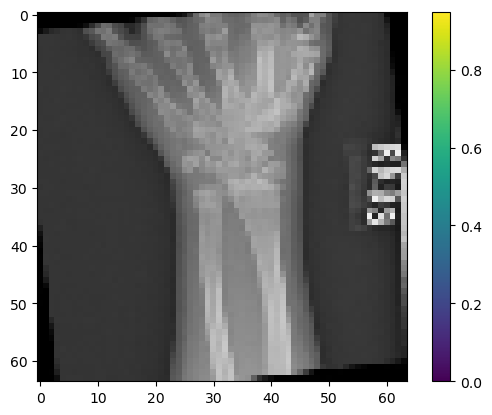

fractured
(64, 64, 3)


In [80]:
visualize_example(X_train[75]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_FRACTURED[y_train[75]]) # Acceso al diccionario
print(X_train[75].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

## Modelo de red convolucional

In [65]:
num_classes = 2
epochs = 5
img_rows,img_cols = IMG_SIZE,IMG_SIZE
input_shape = (img_rows,img_cols,3) #(64,64,3)

In [66]:
# convert class vectors to binary class matrices
print(np.unique(y_train))  # Debería imprimir [0, 1]
print(np.unique(y_val))    # Debería imprimir [0, 1]
print(np.unique(y_test))   # Debería imprimir [0, 1]

[0 1]
[0 1]
[0 1]


In [67]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(64, 64, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.02)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.02))
])

model.compile(
  optimizer='adam',
	loss='binary_crossentropy',
	metrics=['accuracy']
)

early_stopping = EarlyStopping(
	monitor='val_accuracy',
	min_delta=0.01,
	patience=3,
	mode='max',
	restore_best_weights=True
)

In [68]:
history=model.fit(
  X_train, 
  y_train, 
  epochs=15, 
  validation_data=(X_val, y_val),
  callbacks=[early_stopping]
)

Epoch 1/15
288/288 [==============================] - 11s 34ms/step - loss: 1.4829 - accuracy: 0.7055 - val_loss: 0.5026 - val_accuracy: 0.8308
Epoch 2/15
288/288 [==============================] - 9s 30ms/step - loss: 0.4211 - accuracy: 0.8685 - val_loss: 0.4165 - val_accuracy: 0.8822
Epoch 3/15
288/288 [==============================] - 10s 34ms/step - loss: 0.3058 - accuracy: 0.9245 - val_loss: 0.3806 - val_accuracy: 0.9123
Epoch 4/15
288/288 [==============================] - 10s 33ms/step - loss: 0.2512 - accuracy: 0.9487 - val_loss: 0.3327 - val_accuracy: 0.9135
Epoch 5/15
288/288 [==============================] - 9s 32ms/step - loss: 0.2069 - accuracy: 0.9656 - val_loss: 0.2871 - val_accuracy: 0.9323
Epoch 6/15
288/288 [==============================] - 10s 34ms/step - loss: 0.1894 - accuracy: 0.9724 - val_loss: 0.3576 - val_accuracy: 0.9010
Epoch 7/15
288/288 [==============================] - 9s 33ms/step - loss: 0.1658 - accuracy: 0.9791 - val_loss: 0.2550 - val_accuracy: 0.

In [69]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

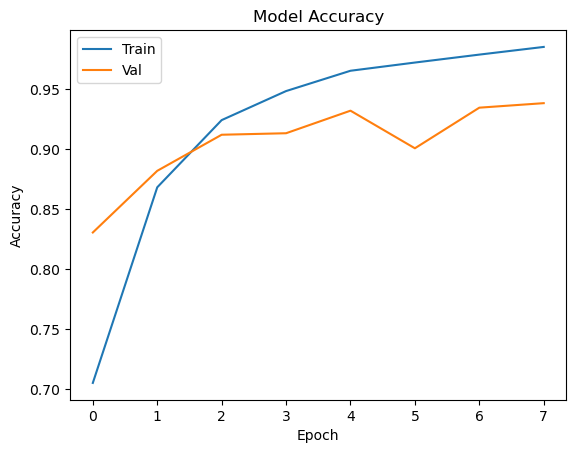

In [70]:
plot_acc(history)

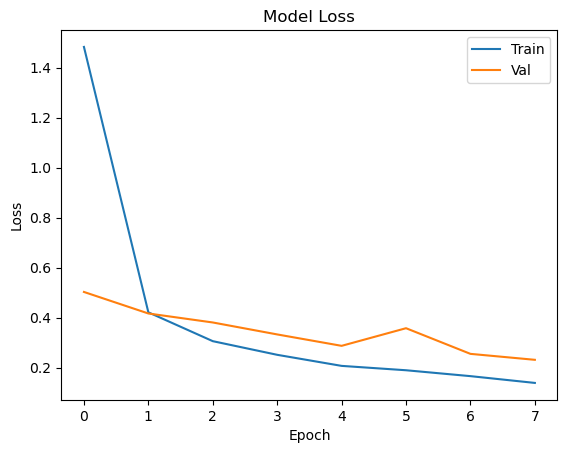

In [71]:
plot_loss(history)